## **Heart Disease Prediction using Logistic Regression, Decision Tree and Artificial Neural Network (ANN)**

### __Importing Dataset__

The dataset was obtained from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease. It is about the Key Heart Disease Indicators, sourced from the 2022 CDC survey involving over 400,000 adults, which primarily examines health-related factors that cause heart disease. Globally, heart disease ranks among the top causes of death across different racial groups, with major risk factors such as high blood pressure, high cholesterol levels, and smoking. Other significant contributors to heart disease include diabetes, obesity, lack of physical activity, and excessive alcohol consumption are taken into consideration. 

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_visualization as dv
import data_preprocessing as dp
import warnings

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import cross_val_score, KFold

warnings.filterwarnings("ignore")

In [2]:
# Open file for heart disease key indicators
heart_disease_df=pd.read_csv("dataset/heart_2022_with_nans.csv")
heart_disease_df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [3]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

We'll use the same set of features* (18 in total) from the 2020 dataset to simplify the analysis. Therefore, we'll exclude additional features introduced in the 2022 dataset, except for `HeightInMeters` and `WeightInKilograms`. These two features are important for calculating missing values in the `BMI` field.

In [4]:
del_columns = ['State', 'LastCheckupTime', 'RemovedTeeth', 'HadDepressiveDisorder', 'HadArthritis', 'HadAngina', 'HadCOPD', 
               'DeafOrHardOfHearing', 'ECigaretteUsage', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'ChestScan',
               'DifficultyDressingBathing', 'DifficultyErrands', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'CovidPos',
               'TetanusLast10Tdap', 'HighRiskLastYear']

heart_disease_df = heart_disease_df.drop(columns=del_columns)
print(f"Number of features: {len(heart_disease_df.columns)}")

Number of features: 20


In [5]:
# Dimension of the dataset
print(f"Shape of the Heart Disease dataset: ({heart_disease_df.shape})")

Shape of the Heart Disease dataset: ((445132, 20))


### __Exploratory Data Analysis__

View the generate descriptive statistics of the dataset

In [6]:
heart_disease_df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434205.000000,436065.000000,439679.000000,416480.000000,403054.000000,396326.000000
mean,4.347919,4.382649,7.022983,1.702691,83.074470,28.529842
std,8.688912,8.387475,1.502425,0.107177,21.448173,6.554889
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


Drop all duplicate records from the dataset

In [7]:
print(f"Record count before dropping duplicates => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df.drop_duplicates()
print(f"Record count after dropping duplicates  => {heart_disease_df.shape[0]}")

Record count before dropping duplicates => 445132


Record count after dropping duplicates  => 431009


Check all records with missing (or null) values

In [8]:
print("List of features with missing values:")
heart_disease_df.isna().sum()

List of features with missing values:


Sex                          0
GeneralHealth             1175
PhysicalHealthDays       10897
MentalHealthDays          9038
PhysicalActivities        1069
SleepHours                5413
HadHeartAttack            3038
HadStroke                 1530
HadAsthma                 1746
HadSkinCancer             3116
HadKidneyDisease          1899
HadDiabetes               1060
DifficultyWalking        19808
SmokerStatus             31136
RaceEthnicityCategory    13740
AgeCategory               8444
HeightInMeters           23814
WeightInKilograms        36714
BMI                      43426
AlcoholDrinkers          42185
dtype: int64

There are 3,038 records with missing values found in `HadHeartAttack`, which is the target variable. Hence, we can simply drop all those records, keeping only the records with assigned class labels.

In [9]:
print(f"Record count before dropping null values in 'HadHeartAttack' => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df.dropna(subset=["HadHeartAttack"])
print(f"Record count after dropping null values in 'HadHeartAttack'  => {heart_disease_df.shape[0]}")

Record count before dropping null values in 'HadHeartAttack' => 431009
Record count after dropping null values in 'HadHeartAttack'  => 427971


Check if the target variable `HadHeartAttack` is a binary, wherein it should only have two distinct values, i.e. Yes and No. This feature will be used to predict whether a person has heart disease or not.

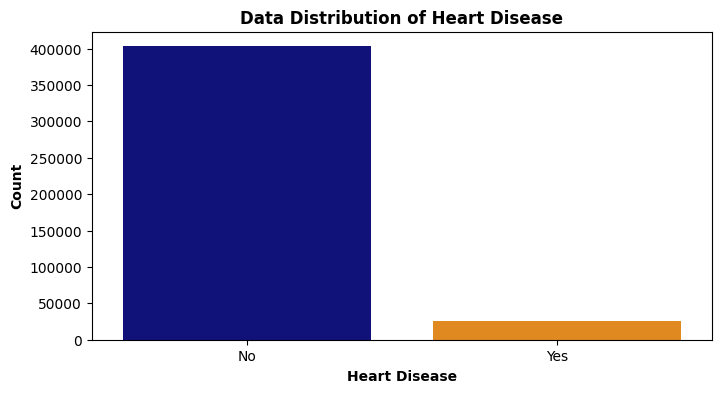

In [10]:
dv.show_bar_graph(df=heart_disease_df,
                  col_="HadHeartAttack",
                  figure_size=(8, 4),
                  title='Data Distribution of Heart Disease',
                  x_label='Heart Disease',
                  y_label='Count',
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

__Observation:__ The chart reveals that there is an imbalance in the number of records for `HadHeartAttack`, showing an uneven distribution of data between individuals who have the illness and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. Ways to fix imbalanced dataset include oversampling minority class, undersampling majority class, adding class weight, generating synthetic samples, etc. In our case, we will be using SMOTEENN (Synthetic Minority Oversampling Technique - Edited Nearest Neighbors) approach to avoid losing information from the majority class. The key idea behind SMOTE is to oversample the minority class by generating synthetic examples, though it sometimes generate noise in the dataset. Hence, ENN is added to remove instances from both the minority and majority classes that are considered potentially misclassified or noisy.

##### __Limiting Data to a Specific Ethnicity__

When building a model for heart disease, considering a particular ethnicity is very important because different ethnic groups can have distinct genetic, lifestyle, and environmental factors that influence the health of the heart. By focusing on a specific ethnicity, we can develop more personalized and accurate models that account for unique risk factors and characteristics within that population.

In [11]:
ethnicity_df = heart_disease_df["RaceEthnicityCategory"].value_counts(dropna=False).reset_index()
ethnicity_df.columns = ["RaceEthnicityCategory", "count"]

print(ethnicity_df)

           RaceEthnicityCategory   count
0       White only, Non-Hispanic  306097
1                       Hispanic   41980
2       Black only, Non-Hispanic   34793
3  Other race only, Non-Hispanic   22195
4                            NaN   13408
5      Multiracial, Non-Hispanic    9498


Therefore, we'll focus solely on the majority of the racial groups, which is `White only, Non-Hispanic`.

In [12]:
print(f"Record count before dropping null values in 'RaceEthnicityCategory' => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df[heart_disease_df['RaceEthnicityCategory'] == 'White only, Non-Hispanic']
print(f"Record count after filtering for 'White only, Non-Hispanic' in 'RaceEthnicityCategory' => {heart_disease_df.shape[0]}")

Record count before dropping null values in 'RaceEthnicityCategory' => 427971
Record count after filtering for 'White only, Non-Hispanic' in 'RaceEthnicityCategory' => 306097


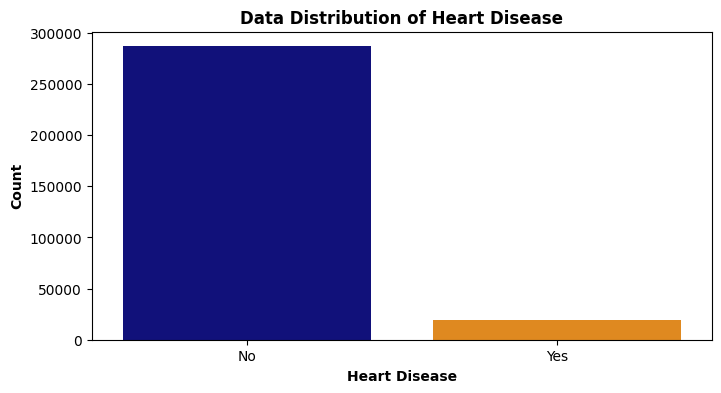

In [13]:
dv.show_bar_graph(df=heart_disease_df,
                  col_="HadHeartAttack",
                  figure_size=(8, 4),
                  title='Data Distribution of Heart Disease',
                  x_label='Heart Disease',
                  y_label='Count',
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

##### __Data Imputation for Missing Values__

Data imputation involves completing or substituting missing values within a dataset. The significance of data imputation lies in its ability to enhance the completeness and reliability of the dataset, ensuring a more comprehensive and accurate representation of the underlying information.

----------------


__i. Data Imputatifor Height and Weight__

Check the skewness of `HeightInMeters` and `WeightInKilograms` within each age category to decide on the appropriate imputation method. Based from the results, majority of height values are slightly skewed to the left, while all weight values are skewed to the right. Therefore, the __*median*__ for each sex and age category group will be used to address the missing values for both height and weight since median is more sensitive to outliers than the mean.

*Example: Female in age 18 to 24 age category has a median height of 1.65 meters and weight of 66.22 kilograms. Hence, these values for will be imputed on missing values in height and weight given this specific group.*

__Skewness Interpretation:__
- If skewness is close to 0, it suggests a relatively symmetrical distribution.
- If skewness is significantly positive, it indicates a right-skewed distribution.
- If skewness is significantly negative, it indicates a left-skewed distribution.

In [14]:
# Replace null values in 'AgeCategory' with a placeholder value (e.g., 'Unknown')
heart_disease_df['AgeCategory'] = heart_disease_df['AgeCategory'].fillna('Unknown')

# Group by 'Sex' and 'AgeCategory' and calculate statistics
skewness_df = heart_disease_df.groupby(['Sex', 'AgeCategory']).agg({
    'HeightInMeters': ['skew', 'count', 'median'],
    'WeightInKilograms': ['skew', 'count', 'median']
}).reset_index()

# Rename columns for clarity
skewness_df.columns = ['Sex', 'AgeCategory', 'HeightSkewness', 'HeightCount', 'HeightMedian', 'WeightSkewness', 'WeightCount', 'WeightMedian']


print("Statistical analysis on height and weight based on sex and age category")
skewness_df

Statistical analysis on height and weight based on sex and age category


,Sex,AgeCategory,HeightSkewness,HeightCount,HeightMedian,WeightSkewness,WeightCount,WeightMedian
0,Female,Age 18 to 24,-0.013026,6069,1.65,1.351164,5876,66.68
1,Female,Age 25 to 29,0.067786,5478,1.65,1.261507,5301,72.57
2,Female,Age 30 to 34,0.110658,7095,1.65,1.351843,6792,72.57
3,Female,Age 35 to 39,0.100868,8395,1.65,1.390566,7973,73.94
4,Female,Age 40 to 44,-0.158525,9281,1.65,1.325938,8781,74.84
5,Female,Age 45 to 49,0.003126,9145,1.65,1.394839,8565,77.11
6,Female,Age 50 to 54,0.052254,11487,1.65,1.235800,10677,77.11
7,Female,Age 55 to 59,-0.090777,13170,1.65,1.136501,12179,74.84
8,Female,Age 60 to 64,-0.009026,16965,1.65,1.103589,15755,74.84
9,Female,Age 65 to 69,0.100167,18295,1.63,1.103935,16936,72.57


In [15]:
# Check for missing values
missing_val_height = heart_disease_df["HeightInMeters"].isnull().sum()
missing_val_weight = heart_disease_df["WeightInKilograms"].isnull().sum()
print(f"Check for missing values in `HeightInMeters` before imputation: {missing_val_height} and `WeightInKilograms` before imputation: {missing_val_weight}")

# Median imputation for Height and Weight
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "HeightInMeters", "HeightMedian")
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "WeightInKilograms", "WeightMedian")

# Check for missing values
missing_val_height = heart_disease_df["HeightInMeters"].isnull().sum()
missing_val_weight = heart_disease_df["WeightInKilograms"].isnull().sum()
print(f"Check for missing values in `HeightInMeters`: {missing_val_height} and `WeightInKilograms`: {missing_val_weight}")

Check for missing values in `HeightInMeters` before imputation: 12222 and `WeightInKilograms` before imputation: 23008
Check for missing values in `HeightInMeters`: 0 and `WeightInKilograms`: 0


__ii. Data Imputation for BMI__

Body Mass Index (BMI) is a metric calculated based on a person's weight and height. The BMI is often used as an indicator of body fatness and is a screening tool to categorize individuals into different weight status categories, such as underweight, normal weight, overweight, and obesity. The formula is:

$$ BMI = {WeightInKilograms \over HeightInMeters^2} $$

To fill in the missing BMI, we will calculate BMI by using a person's weight and height given formula above.

In [16]:
print(f"Record count with missing BMI before data imputation => {heart_disease_df['BMI'].isnull().sum()}")
heart_disease_df=dp.impute_bmi(heart_disease_df)
print(f"Record count with missing BMI after data imputation  => {heart_disease_df['BMI'].isnull().sum()}")

Record count with missing BMI before data imputation => 25968
Record count with missing BMI after data imputation  => 0


We use boxplot to check whether any outliers present in the BMI column. From the chart, a number of outliers are shown. However, we'll just consider the data as outlier if BMI value is more than 100.

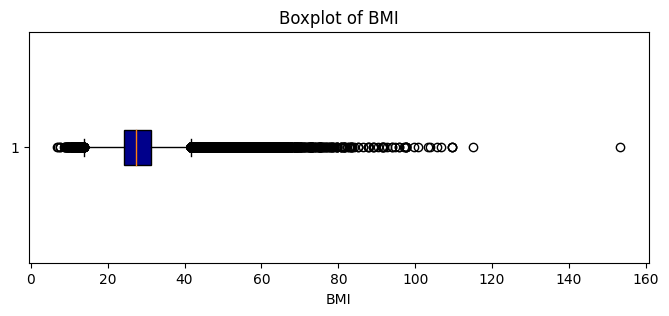

In [17]:
bmi_data = heart_disease_df['BMI'].dropna().tolist()
dv.show_boxplot_graph(data=bmi_data, figure_size=(8,3),title='Boxplot of BMI', x_label='BMI')

In [18]:
# Remove outliers from BMI dataset, i.e. BMI greater 100
heart_disease_df = heart_disease_df[heart_disease_df['BMI'] <= 100]
print(f"Min BMI: {heart_disease_df['BMI'].min()}, Max BMI: {heart_disease_df['BMI'].max()}")

Min BMI: 6.768013327780092, Max BMI: 99.64


__iii. Data Imputation for Age Category__

To fill in the missing age group values, a new column named `WeightStatus` will be created. Its value will be derived from the BMI column. BMI interpretation is based on guidelines available at https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html." 
- Underweight: 0 to 18.59
- Healthy Weight: 18.6 to 24.99
- Overweight: 25.0 to 29.99
- Obesity: 30.0 and above

This new column will be part of the aggregation to get the age category with the highest count per group.

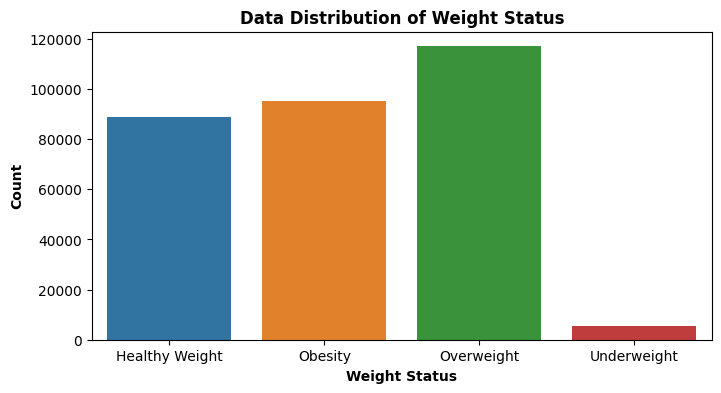

In [19]:
# Create a new column `WeightStatus` with values based on BMI
conditions = [
    (heart_disease_df['BMI'].between(0, 18.6)),
    (heart_disease_df['BMI'].between(18.6, 25.0)),
    (heart_disease_df['BMI'].between(25.0, 30.0)),
    (heart_disease_df['BMI'] >= 30.0)
]

choices = ["Underweight", "Healthy Weight", "Overweight", "Obesity"]

heart_disease_df['WeightStatus'] = np.select(conditions, choices)

# Show data distribution of weight status
dv.show_bar_graph(df=heart_disease_df, 
                  col_="WeightStatus", 
                  figure_size=(8,4),
                  title='Data Distribution of Weight Status', 
                  x_label='Weight Status', 
                  y_label='Count', 
                  x_tick_rotation=None)

For each combination of `Sex`, `WeightStatus`, and `AgeCategory`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `AgeCategory` will be imputed based on the subgroup.

*Example: Majority of underweight females fall into the 'Age 80 or older' category. Hence, that specific age category value will be used to replace the missing data for underweight females.*

In [20]:
print("Statistical analysis for age group based on sex and weight status")
age_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "AgeCategory")
age_result

Statistical analysis for age group based on sex and weight status


,Sex,WeightStatus,AgeCategory,count
12,Female,Healthy Weight,Age 80 or older,7613
23,Female,Obesity,Age 65 to 69,6036
37,Female,Overweight,Age 65 to 69,6927
54,Female,Underweight,Age 80 or older,710
56,Male,Healthy Weight,Age 18 to 24,4096
79,Male,Obesity,Age 65 to 69,5784
93,Male,Overweight,Age 65 to 69,7221
98,Male,Underweight,Age 18 to 24,401


In [21]:
# Converting the 'Unknown' values in AgeCategory column back to null values
heart_disease_df['AgeCategory'] = heart_disease_df['AgeCategory'].replace('Unknown', np.nan)

Number of null values in AgeCategory before imputation:  4648
Number of null values in AgeCategory after imputation:  0


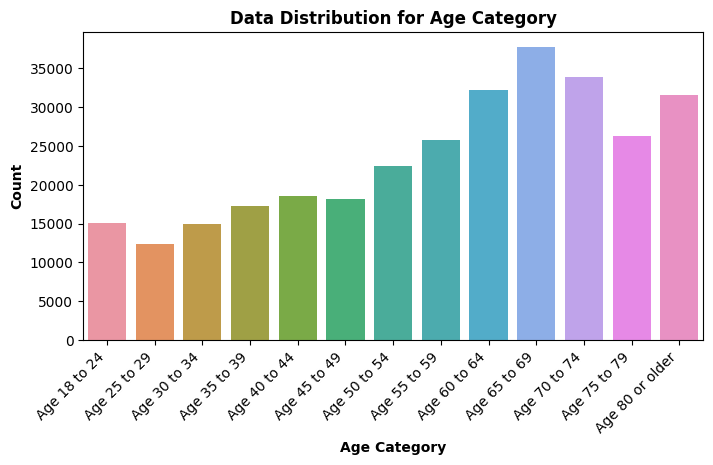

In [22]:
# Impute age category based on sex and weight status
print("Number of null values in AgeCategory before imputation: ", heart_disease_df['AgeCategory'].isnull().sum())
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, age_result, "AgeCategory")
print("Number of null values in AgeCategory after imputation: ", heart_disease_df['AgeCategory'].isnull().sum())

# Show data distribution of age category
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AgeCategory", 
                  figure_size=(8,4),
                  title='Data Distribution for Age Category', 
                  x_label='Age Category',
                  y_label='Count', 
                  x_tick_rotation=45)

__iv. Data Imputation for General Health__

For each combination of `Sex`, `WeightStatus`, and `GeneralHealth`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `GeneralHealth` will be imputed based on the subgroup.

*Example: Majority of underweight females fall into the 'Very Good' health. Hence, that specific general health category value will be used to replace the missing data for underweight females.*

In [23]:
print("Statistical analysis for general health based on sex and weight status")
genhealth_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "GeneralHealth")
genhealth_result

Statistical analysis for general health based on sex and weight status


,Sex,WeightStatus,GeneralHealth,count
4,Female,Healthy Weight,Very good,21369
7,Female,Obesity,Good,19246
14,Female,Overweight,Very good,21937
19,Female,Underweight,Very good,1131
24,Male,Healthy Weight,Very good,12574
27,Male,Obesity,Good,18138
34,Male,Overweight,Very good,22833
37,Male,Underweight,Good,476


In [24]:
# Impute general health based on sex and weight status
print("Number of null values in General Health before imputation: ", heart_disease_df['GeneralHealth'].isnull().sum())
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, genhealth_result, "GeneralHealth")
print("Number of null values in General Health after imputation: ", heart_disease_df['GeneralHealth'].isnull().sum())

Number of null values in General Health before imputation:  648
Number of null values in General Health after imputation:  0


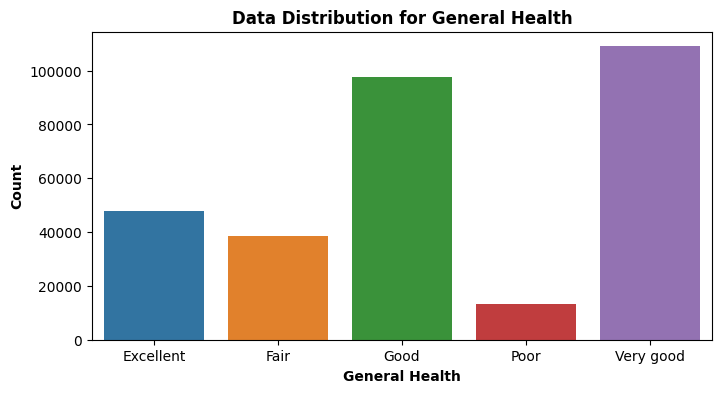

In [25]:
# Show data distribution for general health
dv.show_bar_graph(df=heart_disease_df, 
                  col_="GeneralHealth", 
                  figure_size=(8,4),
                  title='Data Distribution for General Health', 
                  x_label='General Health',
                  y_label='Count')

__v. Data Imputation for Having Diabetes__

For each combination of `Sex`, `AgeCategory`, and `HadDiabetes`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `HadDiabetes` will be imputed based on the subgroup. Based on the information provided in the table below, any missing values in the `HadDiabetes` column will be replced with 'No.'

__NOTE:__ Same approach will be utilized for subsequent data imputations.

In [26]:
print("Statistical analysis for having diabetes based on sex and age category")
diabetes_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadDiabetes")
diabetes_result

Statistical analysis for having diabetes based on sex and age category


,Sex,AgeCategory,HadDiabetes,count
0,Female,Age 18 to 24,No,6159
4,Female,Age 25 to 29,No,5464
8,Female,Age 30 to 34,No,6869
12,Female,Age 35 to 39,No,8022
16,Female,Age 40 to 44,No,8698
20,Female,Age 45 to 49,No,8452
24,Female,Age 50 to 54,No,10205
28,Female,Age 55 to 59,No,11421
32,Female,Age 60 to 64,No,14406
36,Female,Age 65 to 69,No,15815


In [27]:
print("Number of null values in HadDiabetes before imputation: ", heart_disease_df['HadDiabetes'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadDiabetes': 'No'})
print("Number of null values in HadDiabetes after imputation: ", heart_disease_df['HadDiabetes'].isnull().sum())

Number of null values in HadDiabetes before imputation:  397
Number of null values in HadDiabetes after imputation:  0


In [28]:
# Show unique values under smoker status column
heart_disease_df['HadDiabetes'].value_counts().unique

<bound method Series.unique of No                                         256303
Yes                                         40997
No, pre-diabetes or borderline diabetes      6245
Yes, but only during pregnancy (female)      2542
Name: HadDiabetes, dtype: int64>

Combine 'No, pre-diabetes or borderline diabetes' with 'No', and 'Yes, but only during pregnancy (female)' with 'Yes' in `HadDiabetes`

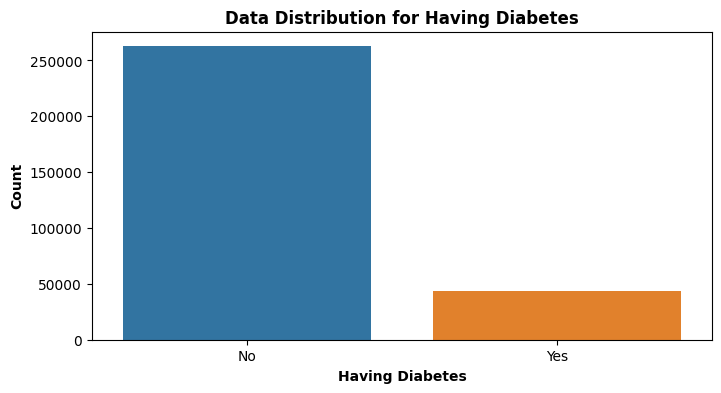

In [29]:
heart_disease_df["HadDiabetes"] = heart_disease_df["HadDiabetes"].apply(
    lambda x: "No" if x == "No, pre-diabetes or borderline diabetes" else (
        "Yes" if x == "Yes, but only during pregnancy (female)" else x
    )
)

# Show data distribution for having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadDiabetes", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Diabetes', 
                  x_label='Having Diabetes',
                  y_label='Count')

__vi. Data Imputation for Having Stroke__

Based on the information provided in the table below, any missing values in the `HadStroke` column will be replaced with 'No.'

In [30]:
print("Statistical analysis for having stroke based on sex and age category")
stroke_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadStroke")
stroke_result

Statistical analysis for having stroke based on sex and age category


,Sex,AgeCategory,HadStroke,count
0,Female,Age 18 to 24,No,6327
2,Female,Age 25 to 29,No,5701
4,Female,Age 30 to 34,No,7366
6,Female,Age 35 to 39,No,8661
8,Female,Age 40 to 44,No,9497
10,Female,Age 45 to 49,No,9353
12,Female,Age 50 to 54,No,11622
14,Female,Age 55 to 59,No,13233
16,Female,Age 60 to 64,No,16837
18,Female,Age 65 to 69,No,18799


In [31]:
print("Number of null values in HadStroke before imputation: ", heart_disease_df['HadStroke'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadStroke': 'No'})
print("Number of null values in HadStroke after imputation: ", heart_disease_df['HadStroke'].isnull().sum())

Number of null values in HadStroke before imputation:  738
Number of null values in HadStroke after imputation:  0


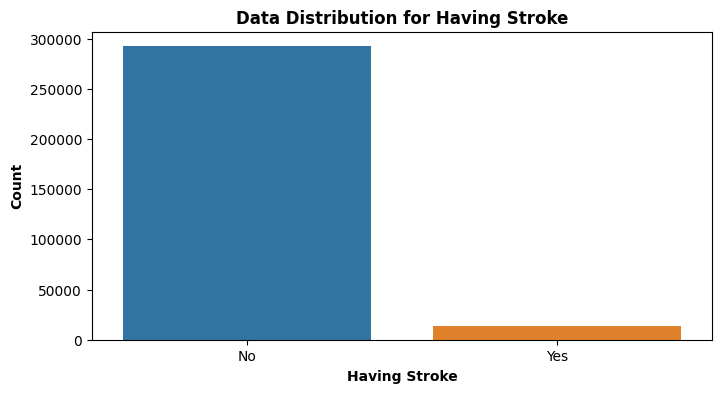

In [32]:
# Show data distribution for having stroke
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadStroke", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Stroke', 
                  x_label='Having Stroke',
                  y_label='Count')

__vii. Data Imputation for Having Asthma__

Based on the information provided in the table below, any missing values in the `HadAsthma` column will be replaced with 'No.'

In [33]:
print("Statistical analysis for having asthma based on sex and age category")
asthma_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadAsthma")
asthma_result

Statistical analysis for having asthma based on sex and age category


,Sex,AgeCategory,HadAsthma,count
0,Female,Age 18 to 24,No,4983
2,Female,Age 25 to 29,No,4462
4,Female,Age 30 to 34,No,5871
6,Female,Age 35 to 39,No,7052
8,Female,Age 40 to 44,No,7711
10,Female,Age 45 to 49,No,7583
12,Female,Age 50 to 54,No,9578
14,Female,Age 55 to 59,No,11136
16,Female,Age 60 to 64,No,14308
18,Female,Age 65 to 69,No,16276


In [34]:
print("Number of null values in HadAsthma before imputation: ", heart_disease_df['HadAsthma'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadAsthma': 'No'})
print("Number of null values in HadAsthma after imputation: ", heart_disease_df['HadAsthma'].isnull().sum())

Number of null values in HadAsthma before imputation:  997
Number of null values in HadAsthma after imputation:  0


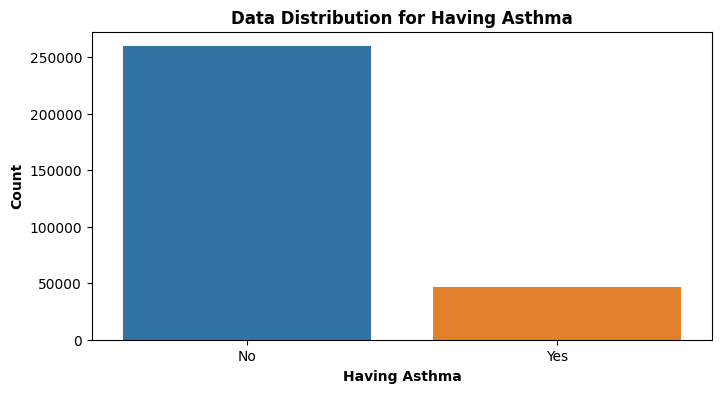

In [35]:
# Show data distribution for having asthma
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadAsthma", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Asthma', 
                  x_label='Having Asthma',
                  y_label='Count')

__viii. Data Imputation for Having Skin Cancer__

Based on the information provided in the table below, any missing values in the `HadSkinCancer` column will be replaced with 'No.'

In [36]:
print("Statistical analysis for having skin cancer based on sex and age category")
skin_cancer_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadSkinCancer")
skin_cancer_result

Statistical analysis for having skin cancer based on sex and age category


,Sex,AgeCategory,HadSkinCancer,count
0,Female,Age 18 to 24,No,6311
2,Female,Age 25 to 29,No,5699
4,Female,Age 30 to 34,No,7329
6,Female,Age 35 to 39,No,8582
8,Female,Age 40 to 44,No,9364
10,Female,Age 45 to 49,No,9144
12,Female,Age 50 to 54,No,11189
14,Female,Age 55 to 59,No,12489
16,Female,Age 60 to 64,No,15571
18,Female,Age 65 to 69,No,16977


In [37]:
print("Number of null values in HadSkinCancer before imputation: ", heart_disease_df['HadSkinCancer'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadSkinCancer': 'No'})
print("Number of null values in HadSkinCancer after imputation: ", heart_disease_df['HadSkinCancer'].isnull().sum())

Number of null values in HadSkinCancer before imputation:  2250
Number of null values in HadSkinCancer after imputation:  0


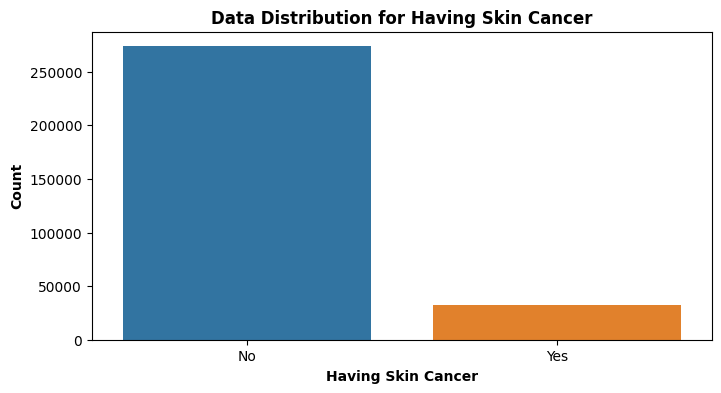

In [38]:
# Show data distribution for having skin cancer
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadSkinCancer", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Skin Cancer', 
                  x_label='Having Skin Cancer',
                  y_label='Count')

__xv. Data Imputation for Having Kidney Disease__

Based on the information provided in the table below, any missing values in the `HadKidneyDisease` column will be replaced with 'No.'

In [39]:
print("Statistical analysis for having kidney disease based on sex and age category")
kidney_disease_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadKidneyDisease")
kidney_disease_result

Statistical analysis for having kidney disease based on sex and age category


,Sex,AgeCategory,HadKidneyDisease,count
0,Female,Age 18 to 24,No,6287
2,Female,Age 25 to 29,No,5675
4,Female,Age 30 to 34,No,7303
6,Female,Age 35 to 39,No,8609
8,Female,Age 40 to 44,No,9463
10,Female,Age 45 to 49,No,9319
12,Female,Age 50 to 54,No,11595
14,Female,Age 55 to 59,No,13124
16,Female,Age 60 to 64,No,16717
18,Female,Age 65 to 69,No,18577


In [40]:
print("Number of Null values in HadkidneyDisease before imputation: ", heart_disease_df['HadKidneyDisease'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadKidneyDisease': 'No'})
print("Number of Null values in HadkidneyDisease after imputation: ", heart_disease_df['HadKidneyDisease'].isnull().sum())

Number of Null values in HadkidneyDisease before imputation:  1068
Number of Null values in HadkidneyDisease after imputation:  0


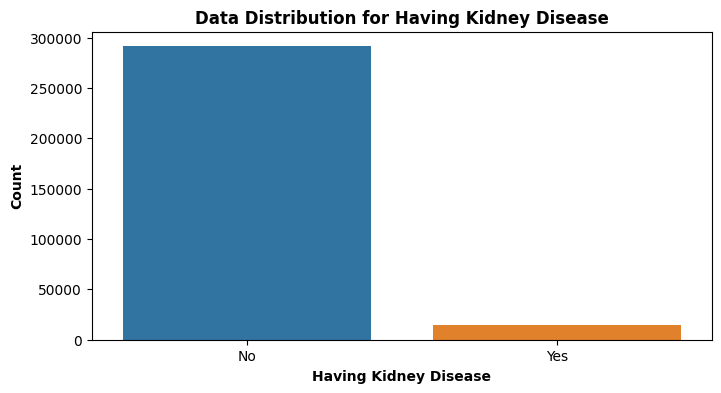

In [41]:
# Show data distribution for having kidney disease
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadKidneyDisease", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Kidney Disease', 
                  x_label='Having Kidney Disease',
                  y_label='Count')

__x. Data Imputation for Smoker and Alcohol Drinker__

Based from the results below, individuals aged 75 and above who are male are mostly former smokers. Other groups indicate that there is no history of smoking.

In [42]:
print("Statistical analysis for smoker status based on sex and age category")
smoker_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SmokerStatus")
smoker_result

Statistical analysis for smoker status based on sex and age category


,Sex,AgeCategory,SmokerStatus,count
3,Female,Age 18 to 24,Never smoked,5203
7,Female,Age 25 to 29,Never smoked,4007
11,Female,Age 30 to 34,Never smoked,4599
15,Female,Age 35 to 39,Never smoked,5085
19,Female,Age 40 to 44,Never smoked,5003
23,Female,Age 45 to 49,Never smoked,5141
27,Female,Age 50 to 54,Never smoked,6618
31,Female,Age 55 to 59,Never smoked,7181
35,Female,Age 60 to 64,Never smoked,8840
39,Female,Age 65 to 69,Never smoked,10436


In [43]:
print("Number of Null values in SmokerStatus before imputation: ", heart_disease_df['SmokerStatus'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = dp.impute_smoking_status(heart_disease_df)
print("Number of Null values in SmokerStatus after imputation: ", heart_disease_df['SmokerStatus'].isnull().sum())

Number of Null values in SmokerStatus before imputation:  18895
Number of Null values in SmokerStatus after imputation:  0


In [44]:
# Show unique values under smoker status column
heart_disease_df['SmokerStatus'].value_counts().unique

<bound method Series.unique of Never smoked                             174593
Former smoker                             89935
Current smoker - now smokes every day     26340
Current smoker - now smokes some days      8611
Never smoker                               6608
Name: SmokerStatus, dtype: int64>

Merge 'Current smoker - now smokes every day' and 'Current smoker - now smokes some days' into 'Current smoker,' and update 'Never smoker' to 'Never smoked' in the `SmokerStatus` column.

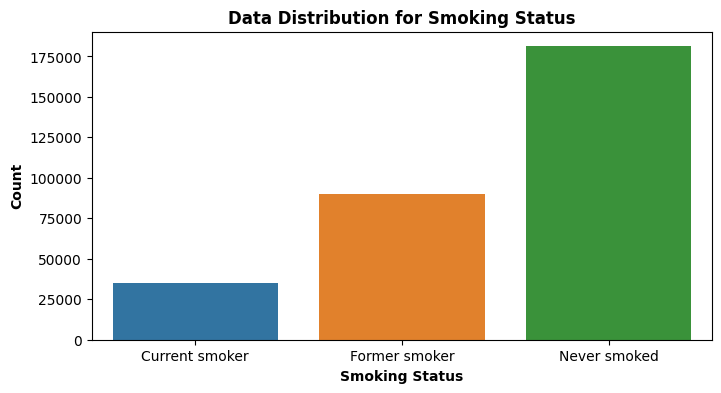

In [45]:
heart_disease_df['SmokerStatus'] = heart_disease_df['SmokerStatus'].replace({
    'Never smoker': 'Never smoked',
    'Current smoker - now smokes every day': 'Current smoker',
    'Current smoker - now smokes some days': 'Current smoker',
})

# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="SmokerStatus", 
                  figure_size=(8,4),
                  title='Data Distribution for Smoking Status', 
                  x_label='Smoking Status',
                  y_label='Count',
                  x_tick_rotation=None)

For the `AlcoholDrinkers` feature, the result below indicates that females aged 65 and older and males aged 80 and older predominantly do not consume alcohol. The other groups within this category are primarily characterized as regular drinkers.

In [46]:
print("Statistical analysis for alcohol drinker based on sex and age category")
alcohol_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "AlcoholDrinkers")
alcohol_result

Statistical analysis for alcohol drinker based on sex and age category


,Sex,AgeCategory,AlcoholDrinkers,count
1,Female,Age 18 to 24,Yes,3398
3,Female,Age 25 to 29,Yes,3383
5,Female,Age 30 to 34,Yes,4143
7,Female,Age 35 to 39,Yes,4899
9,Female,Age 40 to 44,Yes,5352
11,Female,Age 45 to 49,Yes,5123
13,Female,Age 50 to 54,Yes,6307
15,Female,Age 55 to 59,Yes,6807
17,Female,Age 60 to 64,Yes,8358
18,Female,Age 65 to 69,No,9418


In [47]:
print("Number of Null values in AlcoholDrinkers before imputation: ", heart_disease_df['AlcoholDrinkers'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = dp.impute_alcohol_drinker(heart_disease_df)
print("Number of Null values in AlcoholDrinkers after imputation: ", heart_disease_df['AlcoholDrinkers'].isnull().sum())

Number of Null values in AlcoholDrinkers before imputation:  26074
Number of Null values in AlcoholDrinkers after imputation:  0


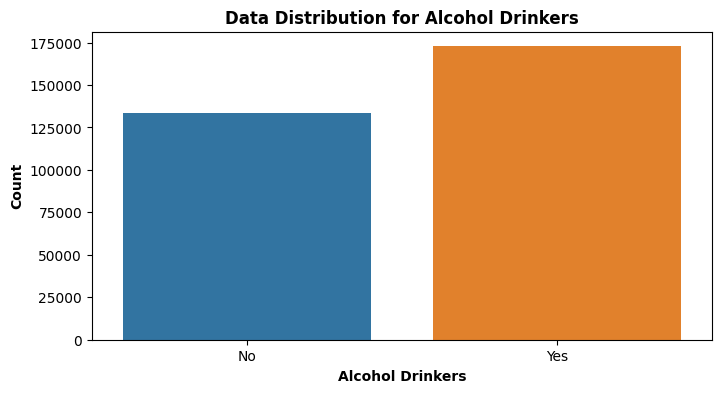

In [48]:

# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AlcoholDrinkers", 
                  figure_size=(8,4),
                  title='Data Distribution for Alcohol Drinkers', 
                  x_label='Alcohol Drinkers',
                  y_label='Count')

__xi. Data Imputation for Physically Active__

Based on the information provided in the table below, any missing values in the `PhysicalActivities` column will be replaced with 'No.'

In [49]:
print("Statistical analysis for physically active group based on sex and age category")
phyactive_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalActivities")
phyactive_result

Statistical analysis for physically active group based on sex and age category


,Sex,AgeCategory,PhysicalActivities,count
1,Female,Age 18 to 24,Yes,5448
3,Female,Age 25 to 29,Yes,4890
5,Female,Age 30 to 34,Yes,6223
7,Female,Age 35 to 39,Yes,7396
9,Female,Age 40 to 44,Yes,7891
11,Female,Age 45 to 49,Yes,7536
13,Female,Age 50 to 54,Yes,9165
15,Female,Age 55 to 59,Yes,10281
17,Female,Age 60 to 64,Yes,13115
19,Female,Age 65 to 69,Yes,14577


In [50]:
print("Number of Null values in PhysicalActivities before imputation: ", heart_disease_df['PhysicalActivities'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'PhysicalActivities': 'Yes'})
print("Number of Null values in PhysicalActivities after imputation: ", heart_disease_df['PhysicalActivities'].isnull().sum())

Number of Null values in PhysicalActivities before imputation:  649
Number of Null values in PhysicalActivities after imputation:  0


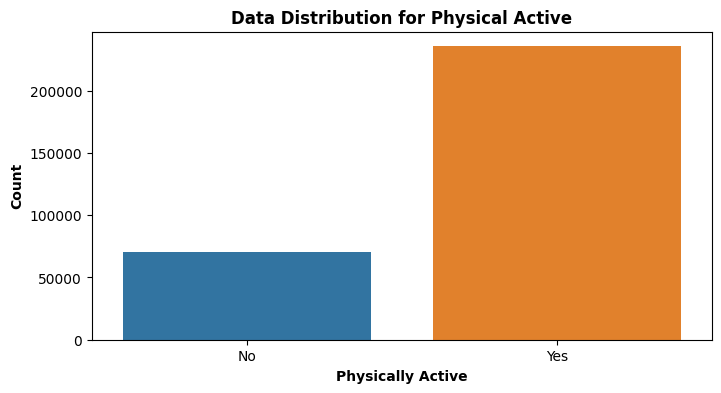

In [51]:
# Show data distribution for Physically Active
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalActivities", 
                  figure_size=(8,4),
                  title='Data Distribution for Physical Active', 
                  x_label='Physically Active',
                  y_label='Count')

__xii. Data Imputation for Difficulty Walking__

Based on the information provided in the table below, any missing values in the `DifficultyWalking` column will be replaced with 'No.'

In [52]:
print("Statistical analysis for difficulty of walking based on sex and age category")
diffwalking_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "DifficultyWalking")
diffwalking_result

Statistical analysis for difficulty of walking based on sex and age category


,Sex,AgeCategory,DifficultyWalking,count
0,Female,Age 18 to 24,No,5867
2,Female,Age 25 to 29,No,5302
4,Female,Age 30 to 34,No,6802
6,Female,Age 35 to 39,No,7953
8,Female,Age 40 to 44,No,8584
10,Female,Age 45 to 49,No,8225
12,Female,Age 50 to 54,No,9878
14,Female,Age 55 to 59,No,10839
16,Female,Age 60 to 64,No,13673
18,Female,Age 65 to 69,No,15203


In [53]:
print("Number of Null values in DifficultyWalking before imputation: ", heart_disease_df['DifficultyWalking'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'DifficultyWalking': 'No'})
print("Number of Null values in DifficultyWalking after imputation: ", heart_disease_df['DifficultyWalking'].isnull().sum())

Number of Null values in DifficultyWalking before imputation:  11359
Number of Null values in DifficultyWalking after imputation:  0


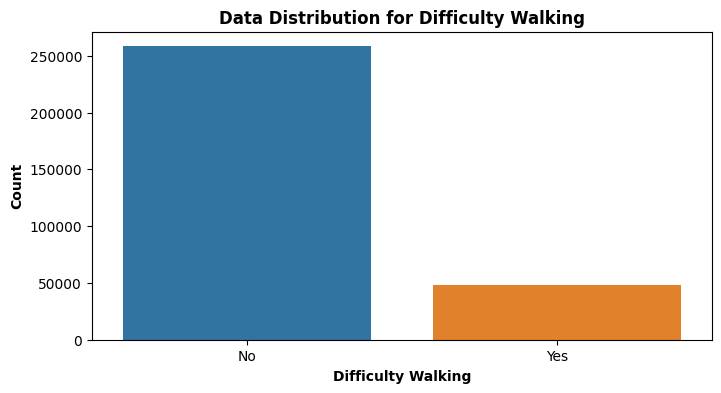

In [54]:
# Show data distribution for difficulty walking
dv.show_bar_graph(df=heart_disease_df, 
                  col_="DifficultyWalking", 
                  figure_size=(8,4),
                  title='Data Distribution for Difficulty Walking', 
                  x_label='Difficulty Walking',
                  y_label='Count')

__xiii. Data Imputation for Physical and Mental Health Days__

Based on the information provided in the table below, any missing values in the `PhysicalHealthDays` column will be replaced with 'No.'

In [55]:
print("Statistical analysis for physical health days based on sex and age category")
phyhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalHealthDays")
phyhealthdays_result

Statistical analysis for physical health days based on sex and age category


,Sex,AgeCategory,PhysicalHealthDays,count
0,Female,Age 18 to 24,0.0,3249
31,Female,Age 25 to 29,0.0,3135
61,Female,Age 30 to 34,0.0,3968
92,Female,Age 35 to 39,0.0,4847
121,Female,Age 40 to 44,0.0,5327
152,Female,Age 45 to 49,0.0,5203
183,Female,Age 50 to 54,0.0,6534
214,Female,Age 55 to 59,0.0,7507
245,Female,Age 60 to 64,0.0,9682
276,Female,Age 65 to 69,0.0,11283


In [56]:
print("Number of Null values in PhysicalHealthDays before imputation: ", heart_disease_df['PhysicalHealthDays'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'PhysicalHealthDays': 0})
print("Number of Null values in PhysicalHealthDays after imputation: ", heart_disease_df['PhysicalHealthDays'].isnull().sum())

Number of Null values in PhysicalHealthDays before imputation:  6618
Number of Null values in PhysicalHealthDays after imputation:  0


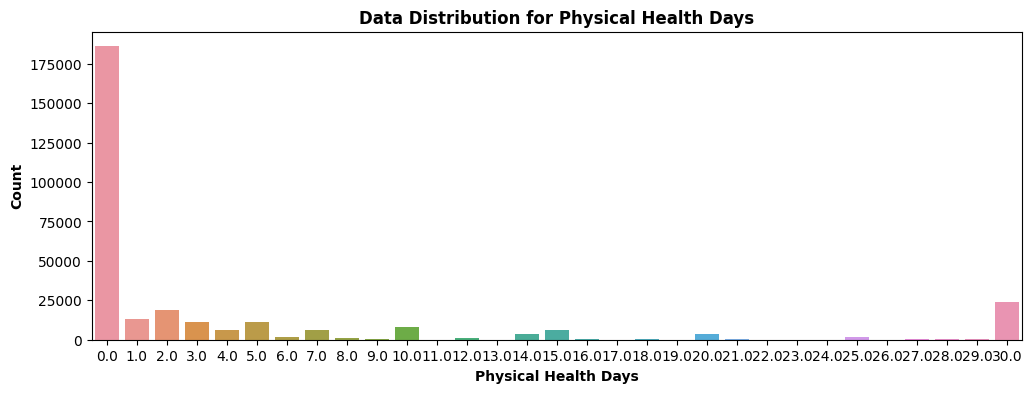

In [57]:
# Show data distribution for physical health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalHealthDays", 
                  figure_size=(12,4),
                  title='Data Distribution for Physical Health Days', 
                  x_label='Physical Health Days',
                  y_label='Count')

Calculate the ratio of records where the value in the `PhysicalHealthDays` column is equal to 0. Need to note that zero (0) has a ratio of 60.76% out of 30 values in the dataset.

In [58]:
zero_val_ratio = heart_disease_df[heart_disease_df["PhysicalHealthDays"] == 0].shape[0] / heart_disease_df.shape[0]
print(f"{round(zero_val_ratio * 100, 2)}% of the records comprise zero (0) values.")

60.76% of the records comprise zero (0) values.


Based on the information provided in the table below, any missing values in the `MentalHealthDays` column will be replaced with 'No.'

In [59]:
print("Statistical analysis for mental health days based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "MentalHealthDays")
menhealthdays_result

Statistical analysis for mental health days based on sex and age category


,Sex,AgeCategory,MentalHealthDays,count
0,Female,Age 18 to 24,0.0,1204
31,Female,Age 25 to 29,0.0,1442
62,Female,Age 30 to 34,0.0,2219
93,Female,Age 35 to 39,0.0,3024
124,Female,Age 40 to 44,0.0,3753
155,Female,Age 45 to 49,0.0,4093
184,Female,Age 50 to 54,0.0,5590
215,Female,Age 55 to 59,0.0,6978
244,Female,Age 60 to 64,0.0,9977
275,Female,Age 65 to 69,0.0,12132


In [60]:
print("Number of null values in MentalHealthDays before imputation: ", heart_disease_df['MentalHealthDays'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'MentalHealthDays': 0})
print("Number of null values in MentalHealthDays after imputation: ", heart_disease_df['MentalHealthDays'].isnull().sum())

Number of null values in MentalHealthDays before imputation:  5496
Number of null values in MentalHealthDays after imputation:  0


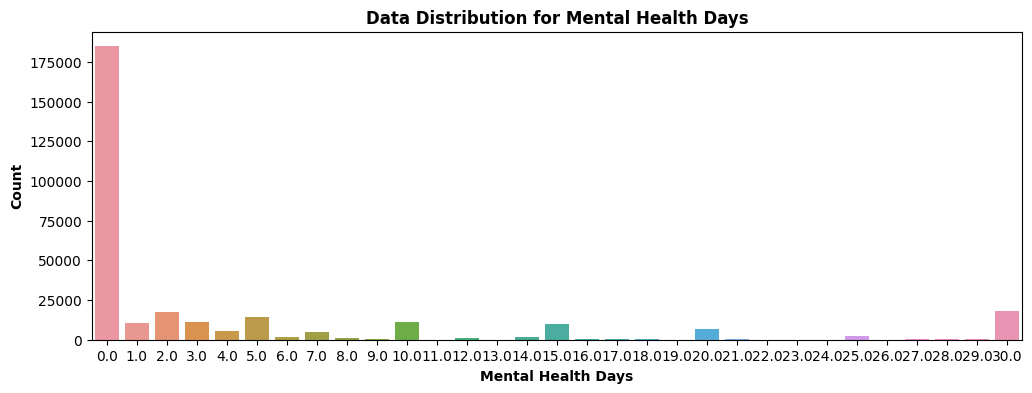

In [61]:
# Show data distribution for mental health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="MentalHealthDays", 
                  figure_size=(12,4),
                  title='Data Distribution for Mental Health Days', 
                  x_label='Mental Health Days',
                  y_label='Count')

Calculate the ratio of records where the value in the `MentalHealthDays` column is equal to 0. Need to note that zero (0) has a ratio of 60.4% out of 30 values in the dataset.

In [62]:
zero_val_ratio = heart_disease_df[heart_disease_df["MentalHealthDays"] == 0].shape[0] / heart_disease_df.shape[0]
print(f"{round(zero_val_ratio * 100, 2)}% of the records comprise zero (0) values.")

60.4% of the records comprise zero (0) values.


If one category represents a significant portion of the data, it may not contribute much information to the model and can potentially lead to overfitting or bias. Hence, we'll be dropping `PhysicalHealthDays` and `MentalHealthDays` from the features since zero (0) has more than 60% ratio out of 30 values.

In [63]:
heart_disease_df = heart_disease_df.drop(columns=['MentalHealthDays', 'PhysicalHealthDays'], axis=1)
print(f"Columns: {heart_disease_df.columns}")

Columns: Index(['Sex', 'GeneralHealth', 'PhysicalActivities', 'SleepHours',
       'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus',
       'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'WeightStatus'],
      dtype='object')


__xiv. Data Imputation for Sleeping Hours__

Based from the results below, individuals aged 65 years and older have an average sleep duration of 8 hours, while other age groups typically sleep for seven hours on average.

In [64]:
print("Statistical analysis for sleep hours based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SleepHours")
menhealthdays_result

Statistical analysis for sleep hours based on sex and age category


,Sex,AgeCategory,SleepHours,count
6,Female,Age 18 to 24,7.0,1902
24,Female,Age 25 to 29,7.0,1817
41,Female,Age 30 to 34,7.0,2313
60,Female,Age 35 to 39,7.0,2968
77,Female,Age 40 to 44,7.0,3241
95,Female,Age 45 to 49,7.0,3198
115,Female,Age 50 to 54,7.0,3852
136,Female,Age 55 to 59,7.0,4438
158,Female,Age 60 to 64,7.0,5584
178,Female,Age 65 to 69,8.0,6106


In [65]:
print("Number of Null values in SleepHours before imputation: ", heart_disease_df['SleepHours'].isnull().sum())
# Impute sleep hours based on sex and weight status
heart_disease_df = dp.impute_sleep_hours(heart_disease_df)
print("Number of Null values in SleepHours after imputation: ", heart_disease_df['SleepHours'].isnull().sum())

Number of Null values in SleepHours before imputation:  2959
Number of Null values in SleepHours after imputation:  0


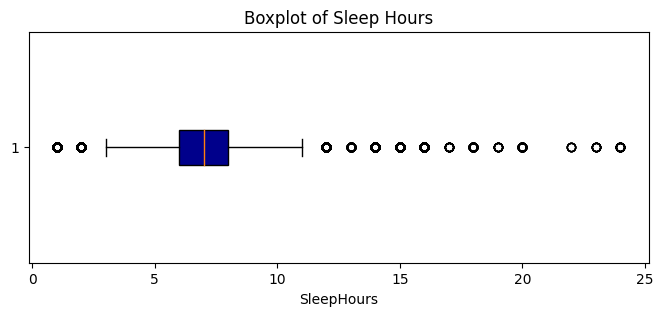

In [66]:
sleep_hours = heart_disease_df['SleepHours'].tolist()
sleep_hours = pd.to_numeric(sleep_hours, errors='coerce')
dv.show_boxplot_graph(data=sleep_hours, figure_size=(8,3),title='Boxplot of Sleep Hours', x_label='SleepHours')

We will eliminate any outliers present in the dataset to enhance the accuracy and reliability of our analysis.

In [67]:
heart_disease_df = heart_disease_df[(heart_disease_df['SleepHours'] >= 3) & (heart_disease_df['SleepHours'] <= 11)]
print(f"Min Sleep Hours: {heart_disease_df['SleepHours'].min()}, Max Sleep Hours: {heart_disease_df['SleepHours'].max()}")

Min Sleep Hours: 3.0, Max Sleep Hours: 11.0


Remove redundant features, i.e. WeightStatus, HeightInMeters, WeightInKilograms, as they are solely utilized for BMI calculation and imputation of the person's age category and general health. Furthermore, given that we restrict the RaceEthnicityCategory to 'White only, Non-Hispanic', we will exclude this feature from consideration since it contains only a one value.

In [68]:
columns_to_drop = ['WeightStatus', 'RaceEthnicityCategory', 'HeightInMeters', 'WeightInKilograms']
heart_disease_df = heart_disease_df.drop(columns=columns_to_drop)
print(f"Columns: {heart_disease_df.columns}")

Columns: Index(['Sex', 'GeneralHealth', 'PhysicalActivities', 'SleepHours',
       'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus',
       'AgeCategory', 'BMI', 'AlcoholDrinkers'],
      dtype='object')


__Pearson Correlation__

Determine all numerical features first before checking if there is a high correlation between the data by using pearson correlation. The graph indicates that there are no strongly correlated numerical variables, with the highest correlation being -0.066.

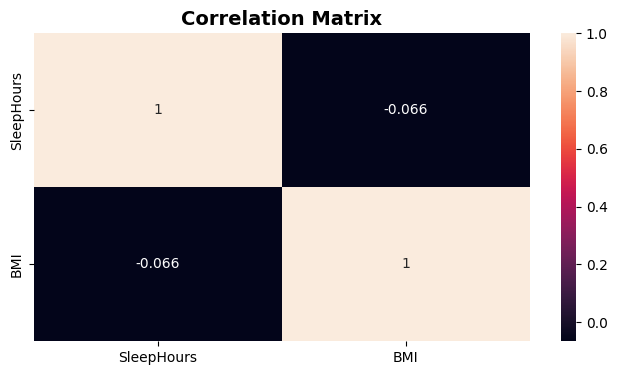

In [143]:
numeric_features_df = heart_disease_df.select_dtypes(include=['number'])

plt.figure(figsize=(8,4))
sns.heatmap(numeric_features_df.corr(), annot=True)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.show()

### __Dimentionality Reduction__

In machine learning, dimensionality reduction is a method employed to decrease the number of features or variables in a dataset while maintaining crucial information or patterns. The aim is to streamline the data without sacrificing essential details or impacting the performance of machine learning models.

### __Feature Engineering__

Feature engineering is important as it helps create valuable data representations for machine learning. This process includes encoding categorical variables, scaling numerical features, and handling class imbalances, ensuring the data is in a format that enhances the model's accuracy and effectiveness. By optimizing features, feature engineering contributes significantly to the overall performance of machine learning models.

##### __Encoding Categorical Features__

Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [70]:
# Get all categorical columns
categorical_columns = [name for name in heart_disease_df.columns if heart_disease_df[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 13 categorical features:

Sex, GeneralHealth, PhysicalActivities, HadHeartAttack, HadStroke, HadAsthma, HadSkinCancer, HadKidneyDisease, HadDiabetes, DifficultyWalking, SmokerStatus, AgeCategory, AlcoholDrinkers


In [71]:
feature_no_drop = ['GeneralHealth', 'AgeCategory', 'RaceEthnicityCategory']

categorical_drop_first = [name for name in categorical_columns if name not in feature_no_drop]
categorical_no_drop = [name for name in categorical_columns if name in feature_no_drop]

heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df, columns=categorical_drop_first, drop_first=True)
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_dummy, columns=categorical_no_drop)
heart_disease_df_dummy.head(5)

,SleepHours,BMI,Sex_Male,PhysicalActivities_Yes,HadHeartAttack_Yes,HadStroke_Yes,HadAsthma_Yes,HadSkinCancer_Yes,HadKidneyDisease_Yes,HadDiabetes_Yes,...,AgeCategory_Age 35 to 39,AgeCategory_Age 40 to 44,AgeCategory_Age 45 to 49,AgeCategory_Age 50 to 54,AgeCategory_Age 55 to 59,AgeCategory_Age 60 to 64,AgeCategory_Age 65 to 69,AgeCategory_Age 70 to 74,AgeCategory_Age 75 to 79,AgeCategory_Age 80 or older
0,8.0,25.515625,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,6.0,26.570000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5.0,25.610000,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7.0,23.300000,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,9.0,21.770000,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


After encoding all categorical variables, we have 31 input features available for training the model, excluding the target variable.

In [144]:
print(f"Shape of the dataset: ({heart_disease_df_dummy.shape})")

Shape of the dataset: ((301908, 32))


##### __Splitting Dataset to Train, Test and Validation__

There are a total of 301,758 records. We will divide the data into training, validation and testing sets, with 20% reserved for testing.

In [72]:
# Split into feature variable and target variable
X = heart_disease_df_dummy.drop(columns='HadHeartAttack_Yes')
y = heart_disease_df_dummy['HadHeartAttack_Yes']

In [73]:
# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Shape of the train dataset: ({X_train.shape}, {y_train.shape})")
print(f"Shape of the validation dataset: ({X_val.shape}, {y_val.shape})")
print(f"Shape of the test dataset: ({X_test.shape}, {y_test.shape})")

Shape of the train dataset: ((193220, 31), (193220,))
Shape of the validation dataset: ((48306, 31), (48306,))
Shape of the test dataset: ((60382, 31), (60382,))


##### __Balancing Class Distribution__

Balancing the data is important to prevent machine learning models from being biased toward the majority class, ensuring fair and accurate predictions across all classes. We will be utilizing SMOTEENN (SMOTE-ENN) or "Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors", a combination of two data sampling techniques used in machine learning to balance the dataset. The synthetic data will be generated using SMOTE to achieve a balanced distribution of data across all classes. The ENN is used to remove instances from both the minority and majority classes that are considered potentially misclassified or noisy.

__Finding Optimal Value for k-Nearest Neighbors for SMOTE__

Determine the optimal k value to be utilized for SMOTE's k-nearest neighbors during the creation of synthetic samples.

In [151]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [20, 25, 30]}

# Create a k-nearest neighbors classifier
knn = KNeighborsClassifier()

# Use grid search to find the optimal value of k
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameter and score
best_param = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameter: {best_param}")
print(f"Best score: {round(best_score, 2)}")

Best parameter: {'n_neighbors': 25}
Best score: 0.94


__Creating Synthetic Data using SMOTEENN__

Synthetic data will be generated using SMOTEENN to achieve a balanced distribution of data across all classes. The parameter k_neighbors for SMOTE will be set to 25, determined as the optimal value during the hyperparameter tuning of k-nearest neighbors.

In [152]:
# Create instance of SMOTE
smote = SMOTE(k_neighbors=best_param['n_neighbors'], random_state=42)

# Create instance of SMOTEENN 
smoteenn = SMOTEENN(random_state=42, smote=smote)
print(f"{smoteenn}")

SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=25, random_state=42))


The original count of records for the 'with Heart Disease' class has now been balanced with the 'without Heart Disease' class, resulting in a total of 152,718 records for both classes

In [153]:
# X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

# print(f'No. of records before using SMOTE\n{y_train.value_counts()}\n')
# print(f'No. of records after using SMOTE\n{y_train_smoted.value_counts()}')

X_train_smoted, y_train_smoted = smoteenn.fit_resample(X_train, y_train)

print(f'No. of records before using SMOTEENN\n{y_train.value_counts()}\n')
print(f'No. of records after using SMOTEENN\n{y_train_smoted.value_counts()}')

No. of records before using SMOTEENN
0    181272
1     11948
Name: HadHeartAttack_Yes, dtype: int64

No. of records after using SMOTEENN
1    162451
0    134626
Name: HadHeartAttack_Yes, dtype: int64


##### __Scaling Dataset__

Scaling the dataset is important for machine learning models as it ensures that features with different scales contribute equally. Standardization, a scaling technique, enhances model performance by transforming features to have zero mean and unit variance, promoting stable and efficient learning. Scaling is done before data normalization to avoid data leakage, when information outside the training dataset is used to create a model.

In [154]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_smoted)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)

### __Model Creation and Evaluation__

The  objective is to predict whether an individual has heart disease, which falls under a classification problem. For the model training phase, four distinct classification algorithms are used.

- Logistic Regression
- Decision Tree
- Artificial Neural Network (ANN)

##### __Logistic Regression__

Logistic regression is a statistical method used for binary classification, predicting the probability of an observation belonging to one of two classes. It models the relationship between the input features and the likelihood of the outcome using the logistic function.

In [199]:
LR_model = LogisticRegression(C=0.1, penalty='l1', solver='saga')

# Define a grid of hyperparameter values to search
param_grid = {
    'penalty': ['l1'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search = GridSearchCV(LR_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sc, y_train_smoted)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best logistic regression model
best_LR_model = grid_search.best_estimator_
print(f"Best model: {best_LR_model}")

LogisticRegression(C=0.1, penalty='l1', solver='saga')

Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     56622
           1       0.17      0.63      0.26      3760

    accuracy                           0.78     60382
   macro avg       0.57      0.71      0.57     60382
weighted avg       0.92      0.78      0.84     60382



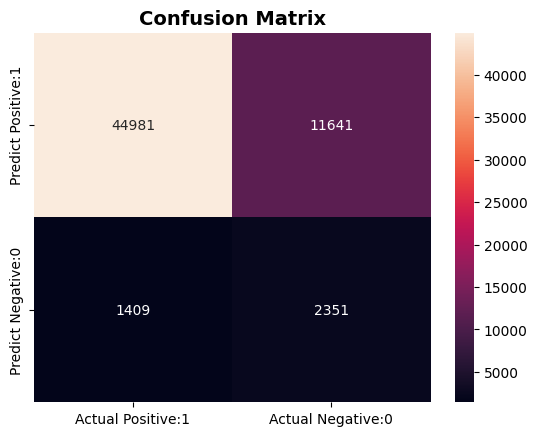

In [200]:
def evaluation_metrics(model, X, y, nn=False):
    # For neural network
    if nn == True:
        y_prob = model.predict(X)
        y_pred = (y_prob > 0.5).astype(int)
        # y_pred = np.argmax(y_prob, axis=1)
    # For machine learning
    else:
        y_pred = model.predict(X)

    print("Classification Report of Test Dataset\n")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()

    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')


evaluation_metrics(LR_model, X_test_sc, y_test)

##### __Decision Tree Classifier__

A decision tree classifier is a predictive modeling algorithm that recursively partitions data based on feature conditions, constructing a tree-like structure to make sequential decisions and assign classifications to instances. It is widely used for both classification and regression tasks in machine learning.

In [132]:
DT_model = DecisionTreeClassifier()

# Define a grid of hyperparameter values to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(DT_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best logistic regression model
best_DT_model = grid_search.best_estimator_
print(f"Best model: {best_DT_model}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best model: DecisionTreeClassifier()


Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     56622
           1       0.13      0.31      0.18      3760

    accuracy                           0.83     60382
   macro avg       0.54      0.59      0.54     60382
weighted avg       0.90      0.83      0.86     60382



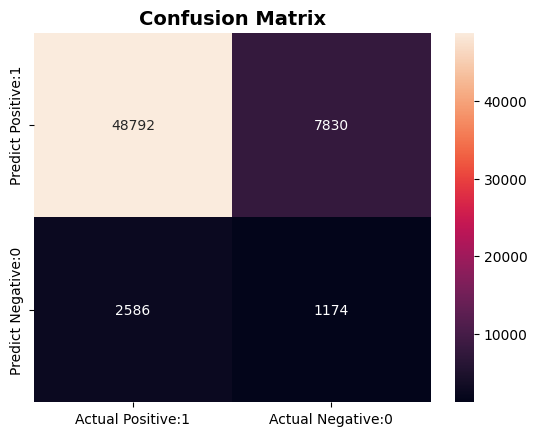

In [157]:
evaluation_metrics(best_DT_model, X_test_sc, y_test)

##### __Artificial Neural Network (ANN)__

In [203]:
# Design the architecture of the neural network
Layers = [
    Dense(units=31, activation="sigmoid", input_shape=X_train_sc.shape[1:], name='InputLayer'),
    BatchNormalization(name='BatchNormalization1'),
    Dense(units=21, activation="sigmoid", name='HiddenLayer1'),
    BatchNormalization(name='BatchNormalization2'),
    Dense(units=11, activation="sigmoid", name='HiddenLayer2'),
    BatchNormalization(name='BatchNormalization3'),
    Dense(units=1, activation='sigmoid', name='OutputLayer')
]

ANN_model = Sequential(Layers)
ANN_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Dense)          (None, 31)                992       
                                                                 
 BatchNormalization1 (Batch  (None, 31)                124       
 Normalization)                                                  
                                                                 
 HiddenLayer1 (Dense)        (None, 21)                672       
                                                                 
 BatchNormalization2 (Batch  (None, 21)                84        
 Normalization)                                                  
                                                                 
 HiddenLayer2 (Dense)        (None, 11)                242       
                                                                 
 BatchNormalization3 (Batch  (None, 11)              

In [204]:
# Compile the ANN model
ANN_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

__Purpose of callback functions__

- __ReduceLROnPlateau:__ helps in fine-tuning the learning process, potentially allowing the model to converge more effectively
- __ModelCheckpoint:__ ensures that the best model weights are preserved during training, allowing you to later load the model with the best performance

In [205]:
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=5=10),
    ModelCheckpoint(filepath='heart_disease-prediction-ann.h5', save_best_only=True)
]

EPOCHS = 40
# Train the model with validation on the training set
model_history = ANN_model.fit(X_train_sc, y_train_smoted, epochs=EPOCHS, callbacks=callbacks, validation_data=(X_val_sc, y_val))

Epoch 1/40


9284/9284 [==============================] - 19s 2ms/step - loss: 0.2568 - accuracy: 0.8864 - val_loss: 0.4607 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 2/40
9284/9284 [==============================] - 22s 2ms/step - loss: 0.2348 - accuracy: 0.8964 - val_loss: 0.4296 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 3/40
9284/9284 [==============================] - 32s 3ms/step - loss: 0.2308 - accuracy: 0.8978 - val_loss: 0.4451 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 4/40
9284/9284 [==============================] - 47s 5ms/step - loss: 0.2282 - accuracy: 0.8987 - val_loss: 0.3829 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 5/40
9284/9284 [==============================] - 27s 3ms/step - loss: 0.2262 - accuracy: 0.8998 - val_loss: 0.4235 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 6/40
9284/9284 [==============================] - 20s 2ms/step - loss: 0.2254 - accuracy: 0.9004 - val_loss: 0.4434 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 7/40
9284/9284 [==============================] - 20s 2ms

Visualize graphs illustrating the relationship between loss and accuracy with respect to the number of epochs

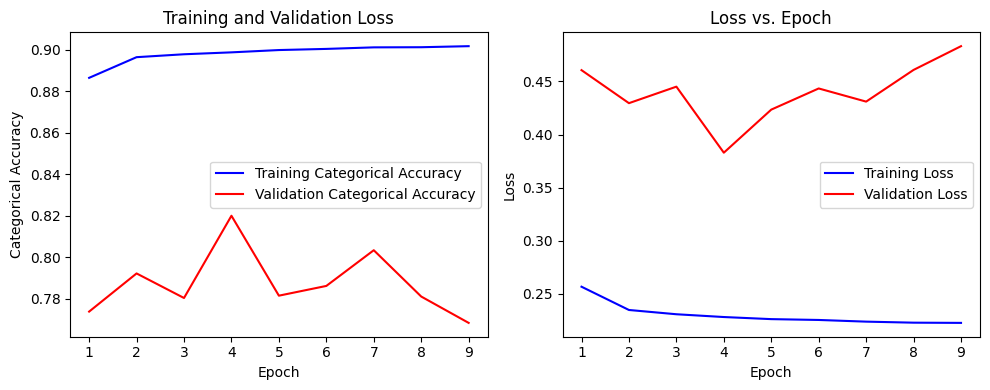

In [215]:
def show_accu_loss_graph(epochs, model):
    # list_of_epochs = list(range(1, epochs+1))
    list_of_loss = model.history['loss']
    list_of_val_loss = model.history['val_loss']
    list_of_accuracy = model.history['accuracy']
    list_of_val_accuracy = model.history['val_accuracy']
    list_of_epochs = list(range(1, len(list_of_loss)+1))

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list_of_epochs, list_of_accuracy, label='Training Categorical Accuracy', color='blue')
    plt.plot(list_of_epochs, list_of_val_accuracy, label='Validation Categorical Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Accuracy')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list_of_epochs, list_of_loss, label='Training Loss', color='blue')
    plt.plot(list_of_epochs, list_of_val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


show_accu_loss_graph(EPOCHS, model_history)

__Evaluating Model:__ Determine the accuracy and the loss metrics for the test dataset

In [216]:
print("Loss:", ANN_model.evaluate(X_test_sc, y_test))

   1/1887 [..............................] - ETA: 39s - loss: 0.2831 - accuracy: 0.8438

1887/1887 [==============================] - 2s 1ms/step - loss: 0.4812 - accuracy: 0.7704
Loss: [0.48121997714042664, 0.7704117298126221]


__Model Prediction:__ The prediction comprises the two activations or probabilities associated with the output neurons corresponding predictions whether a person has heart disease or not. Get the highest probabilities as the final prediction.

   1/1887 [..............................] - ETA: 39s

1887/1887 [==============================] - 2s 1ms/step
Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.97      0.78      0.86     56622
           1       0.16      0.64      0.26      3760

    accuracy                           0.77     60382
   macro avg       0.57      0.71      0.56     60382
weighted avg       0.92      0.77      0.83     60382



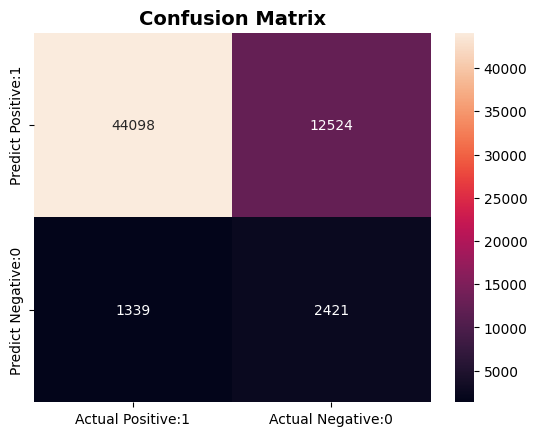

In [217]:
evaluation_metrics(ANN_model, X_test_sc, y_test, nn=True)

### __Hyper Parameter Tuning__

### __References__

- https://towardsdatascience.com/apache-spark-performance-boosting-e072a3ec1179
- https://medium.com/@adrianchang/apache-spark-checkpointing-ebd2ec065371